<p>
    <strong> Notes on Data Collection / Preparation: </strong>
</p>

<p>
    Prior to creating the datasets and models, we went through our current dataset and we compiled all of the folders of images (named according to the person) into one folder. Inside of that folder, we renamed all of the folders with images to measured glucose value of the corresponding person. This process resulted in a folder containing several other folders with glucose values as names of the folders and the folders containing images with those same glucose values. 
</p>
<p>
    We also removed many "bad" images from the datasets; these images were ones that were captured incorrectly. Furthermore, many of the images in the second image capture were renamed to random numbers to allow for the file-folders to be merged into one single folder with subdirectories described above.
</p>

<h1>1 - Initial Setup<h1>

<h4>Importing Necessary Libraries</h4>

In [1]:
import os
import glob
import time
import h5py
import skimage
import statistics
import seaborn as sns
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from PIL import Image
from skimage import io
from skimage import measure
from skimage.color import rgb2gray
from scipy import ndimage
from pathlib import Path


from ClarkeErrorGrid import clarke_error_grid
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import ElasticNet, BayesianRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor, XGBRFRegressor

<h4>Disabling Warnings</h4>

In [656]:
import warnings
warnings.filterwarnings("ignore")

<h1>2 - Declaring Functions </h1>

<h4>Function for Initializing Datasets</h4>

In [2]:
def initDS(num,typestring):
    
    if (typestring == 'measurement'):
        cols = [ 'Red COM' , 'Red Minimum' , 'Red Maximum' , 'Red Median' , 'Red Mean' , 'Red SDT' , 'Red Variance' ,
        'Green COM' , 'Green Minimum' , 'Green Maximum' , 'Green Median' , 'Green Mean' , 'Green SDT' , 'Green Variance' ,
        'Blue COM' , 'Blue Minimum' , 'Blue Maximum' , 'Blue Median' , 'Blue Mean' , 'Blue SDT' , 'Blue Variance' ,
        'Gray COM' , 'Gray Minimum' , 'Gray Maximum' , 'Gray Median' , 'Gray Mean' , 'Gray SDT' , 'Gray Variance' ,
        'Inertia Eigen Val1' , 'Inertia Eigen Val2' , 'Inertia Eigen Val3' , 'Glucose' ]
        dataset = pd.DataFrame(columns=cols,index=range(0,num))
        for col in dataset.columns:
                dataset[col].values[:] = 0
        return dataset
    
    if (typestring == 'intensity'):
        cols = []
        for x in range(0,256):
            cols.append(x)
        cols.append('Glucose')
        dataset = pd.DataFrame(columns=cols,index=range(0,num))
        for col in dataset.columns:
            dataset[col].values[:] = 0
        return dataset

<h4>Function for Extracting Image-Intensity Data</h4>

In [15]:
def fillIntensityDataset(dataset,row,color,i):
    image = io.imread(row['Filepath'])
    rw = dataset.loc[i]
    for a in range(0,480):
        for b in range(0,640):
            sum = image[a][b][color]
            rw[sum] = rw[sum] + 1
    rw.iloc[256] = row['Glucose']

<h4>Function for Extracting Measurement Data</h4>

In [16]:
def fillMeasurementDataset(row,dataset):
    image = io.imread(row['Filepath'])
    rimage = image[:][:][0]
    gimage = image[:][:][1]
    bimage = image[:][:][2]
    rw = dataset.loc[i]
    
    rcom = ndimage.center_of_mass(rimage)
    rext = ndimage.extrema(rimage)
    rw['Red COM'] = rimage[int(rcom[0])][int(rcom[1])].astype('int')
    rw['Red Minimum'] = rext[0].astype('int')
    rw['Red Maximum'] = rext[1].astype('int')
    rw['Red Median'] = ndimage.median(rimage).astype('float')
    rw['Red Mean'] = ndimage.mean(rimage).astype('float')
    rw['Red SDT'] = ndimage.standard_deviation(rimage).astype('float')
    rw['Red Variance'] = ndimage.variance(rimage).astype('float')
    
    gcom = ndimage.center_of_mass(gimage)
    gext = ndimage.extrema(gimage)
    rw['Green COM'] = gimage[int(gcom[0])][int(gcom[1])].astype('int')
    rw['Green Minimum'] = gext[0].astype('int')
    rw['Green Maximum'] = gext[1].astype('int')
    rw['Green Median'] = ndimage.median(gimage).astype('float')
    rw['Green Mean'] = ndimage.mean(gimage).astype('float')
    rw['Green SDT'] = ndimage.standard_deviation(gimage).astype('float')
    rw['Green Variance'] = ndimage.variance(gimage).astype('float')
    
    bcom = ndimage.center_of_mass(bimage)
    bext = ndimage.extrema(bimage)
    rw['Blue COM'] = bimage[int(bcom[0])][int(bcom[1])].astype('int')
    rw['Blue Minimum'] = bext[0].astype('int')
    rw['Blue Maximum'] = bext[1].astype('int')
    rw['Blue Median'] = ndimage.median(bimage).astype('float')
    rw['Blue Mean'] = ndimage.mean(bimage).astype('float')
    rw['Blue SDT'] = ndimage.standard_deviation(bimage).astype('float')
    rw['Blue Variance'] = ndimage.variance(bimage).astype('float')
    
    grimage = rgb2gray(io.imread(row['Filepath']))
    gcom = ndimage.center_of_mass(grimage)
    gext = ndimage.extrema(grimage)
    rw['Gray COM'] = grimage[int(gcom[0])][int(gcom[1])].astype('float')
    rw['Gray Minimum'] = gext[0].astype('float')
    rw['Gray Maximum'] = gext[1].astype('float')
    rw['Gray Median'] = ndimage.median(grimage).astype('float')
    rw['Gray Mean'] = ndimage.mean(grimage).astype('float')
    rw['Gray SDT'] = ndimage.standard_deviation(grimage).astype('float')
    rw['Gray Variance'] = ndimage.variance(grimage).astype('float')
    
    eigen = measure.inertia_tensor_eigvals(image)
    rw['Inertia Eigen Val1'] = eigen[0]
    rw['Inertia Eigen Val2'] = eigen[1]
    rw['Inertia Eigen Val3'] = eigen[2]
    
    rw['Glucose'] = row['Glucose']

<h4>Function for Extracting Timed Data</h4>

In [17]:
def fillTimedDataset(row,i,dataset):
    rw = dataset.loc[i]
    rw['Glucose'] = row['Glucose']
    means = []
    medians = []
    minimums = []
    maximums = []
    sdts = []
    folder_images = glob.glob(row['Filepath'] + '\**')
    for image in folder_images:
        image = image.replace('\\','/')
        img = io.imread(image)
        img = img[:][:][0]
        means.append( ndimage.mean(img) )
        medians.append( ndimage.median(img) )
        minimums.append( ndimage.extrema(img)[0] )
        maximums.append( ndimage.extrema(img)[1] )
        sdts.append( ndimage.standard_deviation(img) )
    rw['Average Mean'] = np.mean( means )
    rw['Average Median'] = np.mean( medians )
    rw['Average Minimum'] = np.mean( minimums )
    rw['Average Maximum'] = np.mean( maximums )
    rw['Average Standard Deviation'] = np.mean( sdts )
    rw['Average Mean Deviation'] = np.std ( means )
    rw['Average Median Deviation'] = np.std ( medians )
    rw['Average Minimum Deviation'] = np.std ( minimums )
    rw['Average Maximum Deviation'] = np.std ( maximums )
    rw['Average Standard Deviation Deviation'] = np.std ( sdts )
    rw['Highest Mean'] = np.max( means )
    rw['Highest Median'] = np.max( medians )
    rw['Highest Minimum'] = np.max( minimums )
    rw['Highest Maximum'] = np.max( maximums )
    rw['Highest Standard Deviation'] = np.max( sdts )
    rw['Lowest Mean'] = np.min( means )
    rw['Lowest Median'] = np.min( medians )
    rw['Lowest Minimum'] = np.min( minimums )
    rw['Lowest Maximum'] = np.min( maximums )
    rw['Lowest Standard Deviation'] = np.min( sdts )

<h4>Function for Training/Testing/Scoring Models</h4>

In [31]:
def trainTest(model,dataset):
    x_train, x_test, y_train, y_test = train_test_split(dataset.drop(columns=['Glucose']), dataset[['Glucose']].astype('float') ,test_size=0.25,random_state=7)
    model.fit(x_train,y_train)
    predictions = model.predict(x_test)
    difference = round(round(mean_squared_error(predictions,y_test,squared=False),2) - round(mean_absolute_error(predictions,y_test),2),2)
    print('MAPE: ' + str(100 - round((mean_absolute_percentage_error(predictions, y_test)*100),2)) + '%')
    print('MAE: ' + str( round(mean_absolute_error(predictions,y_test),2)))
    print('Difference: ' + str(difference))
    actual = y_test.to_numpy()
    clarke_error_grid(actual,predictions,'Glucose Estimation')

<h1>3 - Creating Datasets</h1>

<h4>Finding Raw Data Directory</h4>

In [7]:
directory = os.getcwd() + '\data_second_cleaned'

<h4>Creating Dataframe with Image Filepaths and Values</h4>

In [8]:
#Creating list with all image filepaths and one for glucose values.
files = glob.glob(directory + '\**\*')
values = [None] * len(files)

#Correcting all filepaths and adding their respective values to the other list. 
x = 0
while x < len(files):
    files[x] = files[x].replace('\\','/')
    temp = files[x][59:]
    values[x] = int(temp[0:temp.index('/')])
    x = x + 1

#Converting lists into Panda Series for creating a Dataframe
files = pd.Series(files, name='Filepath')
values = pd.Series(values, name='Glucose')

images = pd.concat([files, values], axis=1)
images

,Filepath,Glucose
0,x:/Machine Learning/Glucose Estimation/data_se...,100
1,x:/Machine Learning/Glucose Estimation/data_se...,100
2,x:/Machine Learning/Glucose Estimation/data_se...,100
3,x:/Machine Learning/Glucose Estimation/data_se...,100
4,x:/Machine Learning/Glucose Estimation/data_se...,100
...,...,...
1123,x:/Machine Learning/Glucose Estimation/data_se...,99
1124,x:/Machine Learning/Glucose Estimation/data_se...,99
1125,x:/Machine Learning/Glucose Estimation/data_se...,99
1126,x:/Machine Learning/Glucose Estimation/data_se...,99


<h4>Shuffling the Dataframe</h4>

In [9]:
#Settings Random State for Replication and Resetting Indices for Ordering 
images = images.sample(1128, random_state=7).reset_index(drop=True)
images

,Filepath,Glucose
0,x:/Machine Learning/Glucose Estimation/data_se...,101
1,x:/Machine Learning/Glucose Estimation/data_se...,83
2,x:/Machine Learning/Glucose Estimation/data_se...,83
3,x:/Machine Learning/Glucose Estimation/data_se...,131
4,x:/Machine Learning/Glucose Estimation/data_se...,113
...,...,...
1123,x:/Machine Learning/Glucose Estimation/data_se...,92
1124,x:/Machine Learning/Glucose Estimation/data_se...,111
1125,x:/Machine Learning/Glucose Estimation/data_se...,142
1126,x:/Machine Learning/Glucose Estimation/data_se...,147


<h4>Initializing the Datasets</h4>

In [10]:
red = initDS(1128,'intensity')
green = initDS(1128,'intensity')
blue = initDS(1128,'intensity')
measurement = initDS(1128,'measurement')

<h4>Filling Datasets</h4>

In [11]:
for i, row in images.iterrows():  
    fillIntensityDataset(red,row,0,i)
    fillIntensityDataset(green,row,1,i)
    fillIntensityDataset(blue,row,2,i)
    fillMeasurementDataset(row,measurement)

<h4>Exporting Datasets</h4>

In [102]:
red.to_csv('red.csv')
green.to_csv('green.csv')
blue.to_csv('blue.csv')
measurement.to_csv('measurement.csv')

<h4>Getting Timed Dataset Directory</h4>

In [13]:
directory = os.getcwd() + '\data_first_cleaned'

<h4>Creating Second Dataframe with Folders and Values</h4>

In [14]:
folders = glob.glob(directory + '\**')
values = [None] * len(folders)

x = 0
while x < len(folders):
    folders[x] = folders[x].replace('\\','/')
    temp = folders[x][58:]
    temp = temp[ 0 : temp.index('_') ]
    values[x] = temp
    x = x + 1

folders = pd.Series(folders, name='Filepath')
values = pd.Series(values, name='Glucose')
folder_values = pd.concat([folders, values], axis=1)
folder_values = folder_values.sample(len(folder_values), random_state=7).reset_index(drop=True)
folder_values

,Filepath,Glucose
0,x:/Machine Learning/Glucose Estimation/data_fi...,123
1,x:/Machine Learning/Glucose Estimation/data_fi...,127
2,x:/Machine Learning/Glucose Estimation/data_fi...,85
3,x:/Machine Learning/Glucose Estimation/data_fi...,110
4,x:/Machine Learning/Glucose Estimation/data_fi...,86
...,...,...
69,x:/Machine Learning/Glucose Estimation/data_fi...,124
70,x:/Machine Learning/Glucose Estimation/data_fi...,95
71,x:/Machine Learning/Glucose Estimation/data_fi...,124
72,x:/Machine Learning/Glucose Estimation/data_fi...,95


<h4>Initializing Empty Datasets</h4>

In [19]:
cols = ['Average Mean','Average Median','Average Minimum','Average Maximum','Average Standard Deviation' ,
        'Average Mean Deviation','Average Median Deviation','Average Minimum Deviation','Average Maximum Deviation','Average Standard Deviation Deviation' ,
        'Highest Mean','Highest Median','Highest Minimum','Highest Maximum','Highest Standard Deviation' ,
        'Lowest Mean','Lowest Median','Lowest Minimum','Lowest Maximum','Lowest Standard Deviation' ,
        'Glucose'
        ]


timed_red = pd.DataFrame(columns=cols,index=range(0,74))
for col in timed_red.columns:
    timed_red[col].values[:] = 0

timed_green = pd.DataFrame(columns=cols,index=range(0,74))
for col in timed_green.columns:
    timed_green[col].values[:] = 0

timed_blue = pd.DataFrame(columns=cols,index=range(0,74))
for col in timed_blue.columns:
    timed_blue[col].values[:] = 0

<h4>Filling Timed Datasets</h4>

In [20]:
for i, row in folder_values.iterrows():
    fillTimedDataset(row,i,timed_red)
    fillTimedDataset(row,i,timed_green)
    fillTimedDataset(row,i,timed_blue)

In [25]:
timed_red

,Average Mean,Average Median,Average Minimum,Average Maximum,Average Standard Deviation,Average Mean Deviation,Average Median Deviation,Average Minimum Deviation,Average Maximum Deviation,Average Standard Deviation Deviation,...,Highest Median,Highest Minimum,Highest Maximum,Highest Standard Deviation,Lowest Mean,Lowest Median,Lowest Minimum,Lowest Maximum,Lowest Standard Deviation,Glucose
0,72.169757,29.166667,0.333333,218.4,74.764843,2.500381,1.545603,0.699206,7.218495,2.881326,...,33.0,2,232,80.206533,68.506771,27.0,0,207,71.408471,123
1,68.488437,26.666667,0.2,212.466667,71.139606,2.047373,1.988858,0.748331,5.18802,1.963951,...,32.0,3,227,74.432103,65.735417,24.0,0,204,67.738735,127
2,69.294167,27.0,0.666667,213.933333,72.411793,1.734595,1.897367,0.942809,4.373659,1.746078,...,31.0,3,222,76.06271,66.798438,23.0,0,208,70.375106,85
3,78.491081,45.5625,0.0,237.5,71.970332,2.049228,2.90944,0.0,2.061553,1.09943,...,52.0,0,241,73.563511,76.191667,43.0,0,235,70.626387,110
4,69.854315,27.464286,0.214286,215.071429,72.541866,1.219119,1.444995,0.410326,5.430921,1.232347,...,30.0,1,224,74.540384,67.770313,24.0,0,205,70.884838,86
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,69.905313,27.133333,0.333333,213.066667,73.055439,1.469464,2.418448,0.699206,4.02437,1.98267,...,31.0,2,221,76.554711,66.774479,23.0,0,207,70.523948,124
70,72.01566,29.033333,0.866667,217.733333,74.545192,1.659868,2.148384,1.203698,3.623381,1.958676,...,33.0,4,224,78.330404,69.483333,25.0,0,213,71.342905,95
71,68.17559,26.466667,0.533333,211.066667,71.043661,1.452518,1.359739,0.884433,4.202645,1.99084,...,30.0,3,218,74.677515,65.592708,25.0,0,204,67.748076,124
72,74.73058,30.0,0.142857,223.571429,77.48065,1.55734,2.203893,0.349927,2.555506,0.82524,...,33.0,1,227,78.77159,73.129167,27.0,0,220,76.386183,95


<h4>Saving Timed Datasets</h4>

In [85]:
timed_red.to_csv('timed_red.csv')
timed_green.to_csv('timed_green.csv')
timed_blue.to_csv('timed_blue.csv')

<h4>Loading All Datasets</h4>

In [26]:
red = pd.read_csv('red.csv')
green = pd.read_csv('green.csv')
blue = pd.read_csv('blue.csv')
rgb = pd.read_csv('rgb.csv')
measurement = pd.read_csv('measurement.csv')

red_measurement = pd.read_csv('red_measurement.csv')
blue_measurement = pd.read_csv('blue_measurement.csv')
green_measurement = pd.read_csv('green_measurement.csv')
rgb_measurement = pd.read_csv('rgb_measurement.csv')

timed_red = pd.read_csv('timed_red.csv')
timed_green = pd.read_csv('timed_green.csv')
timed_blue = pd.read_csv('timed_blue.csv')

<h1>4 - Image Tensor Dataset</h1>

<h4>Creating Image-Tensor Data from Dataframe</h4>

In [27]:
train, test = train_test_split(images, train_size=0.75, shuffle=False, random_state = 7)

train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

train_data = train_generator.flow_from_dataframe(
    dataframe=train,
    x_col='Filepath',
    y_col='Glucose',
    target_size=(120, 160),
    color_mode='rgb',
    class_mode='raw',
    batch_size=32,
    shuffle=False,
    seed=7,
    subset='training'
)

test_data = test_generator.flow_from_dataframe(
    dataframe=test,
    x_col='Filepath',
    y_col='Glucose',
    target_size=(120, 160),
    color_mode='rgb',
    class_mode='raw',
    batch_size=32,
    shuffle=False
)

Found 846 validated image filenames.
Found 282 validated image filenames.


<h4>Creating First CNN Model</h4>

In [28]:
from keras.models import Model
from keras.applications import MobileNetV2
from keras.layers import MaxPool2D, AveragePooling2D, Flatten, Dense, Dropout, Dense

baseModel = MobileNetV2(input_shape=(120, 160, 3) , weights='imagenet' , include_top=False )

for layer in baseModel.layers:
    	layer.trainable = False

headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(2,2))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dropout(0.3)(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dense(1, activation="linear")(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)

In [29]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 120, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 60, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 60, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 60, 80, 32)   0           ['bn_Conv1[0][0]']           

<h4>Compiling and Training Model</h4>

In [39]:
model.compile(
    optimizer='adam',
    loss='mae'
)

model.fit(
    train_data,
    validation_data=test_data,
    epochs=6,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

Epoch 1/6
27/27 [==============================] - 34s 1s/step - loss: 18.0033 - val_loss: 16.6863
Epoch 2/6
27/27 [==============================] - 38s 1s/step - loss: 17.4554 - val_loss: 16.5190
Epoch 3/6
27/27 [==============================] - 37s 1s/step - loss: 17.5347 - val_loss: 16.7778
Epoch 4/6
27/27 [==============================] - 38s 1s/step - loss: 17.1249 - val_loss: 16.7880
Epoch 5/6
27/27 [==============================] - 38s 1s/step - loss: 16.8646 - val_loss: 16.5450


<h4>Testing Model</h4>

9/9 [==============================] - 9s 949ms/step
MAPE: 83.12%
MAE: 16.52
Difference: 6.84


(<module 'matplotlib.pyplot' from 'c:\\Users\\Kazi\\AppData\\Local\\Programs\\Python\\Python310\\lib\\site-packages\\matplotlib\\pyplot.py'>,
 [189, 93, 0, 0, 0])

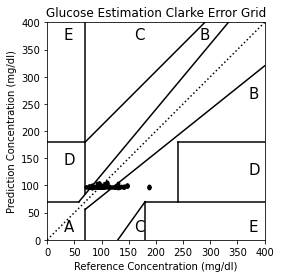

In [40]:
predictions = model.predict(test_data)
difference = round(round(mean_squared_error(predictions,test_data.labels,squared=False),2) - round(mean_absolute_error(predictions,test_data.labels),2),2)
print('MAPE: ' + str(100 - round((mean_absolute_percentage_error(predictions, test_data.labels)*100),2)) + '%')
print('MAE: ' + str( round(mean_absolute_error(predictions,test_data.labels),2)))
print('Difference: ' + str(difference))
actual = test_data.labels
clarke_error_grid(actual,predictions,'Glucose Estimation')

<h4>Creating Second CNN Model</h4>

In [33]:
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.layers import MaxPool2D, AveragePooling2D, Flatten, Dense, Dropout, Dense

baseModel = VGG16(input_shape=(120, 160, 3) , weights='imagenet' , include_top=False )

for layer in baseModel.layers:
    	layer.trainable = False

headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(2,2))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dropout(0.3)(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dense(1, activation="linear")(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)

In [34]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 120, 160, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 120, 160, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 120, 160, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 60, 80, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 60, 80, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 60, 80, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 30, 40, 128)       0   

<h4>Compiling and Training Model</h4>

In [35]:
model.compile(
    optimizer='adam',
    loss='mae'
)

model.fit(
    train_data,
    validation_data=test_data,
    epochs=6,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        )
    ]
)

Epoch 1/6
27/27 [==============================] - 35s 1s/step - loss: 92.3377 - val_loss: 79.0095
Epoch 2/6
27/27 [==============================] - 34s 1s/step - loss: 59.0523 - val_loss: 36.1399
Epoch 3/6
27/27 [==============================] - 34s 1s/step - loss: 22.7757 - val_loss: 17.6741
Epoch 4/6
27/27 [==============================] - 36s 1s/step - loss: 17.9904 - val_loss: 16.5513
Epoch 5/6
27/27 [==============================] - 38s 1s/step - loss: 18.1229 - val_loss: 16.6299
Epoch 6/6
27/27 [==============================] - 38s 1s/step - loss: 17.5542 - val_loss: 16.5890


<h4>Testing Model</h4>

9/9 [==============================] - 10s 1s/step
MAPE: 83.35%
MAE: 16.59
Difference: 6.39


(<module 'matplotlib.pyplot' from 'c:\\Users\\Kazi\\AppData\\Local\\Programs\\Python\\Python310\\lib\\site-packages\\matplotlib\\pyplot.py'>,
 [195, 87, 0, 0, 0])

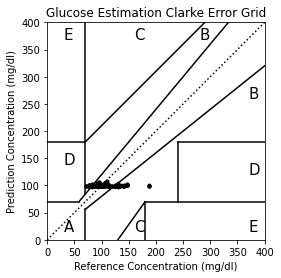

In [38]:
predictions = model.predict(test_data)
difference = round(round(mean_squared_error(predictions,test_data.labels,squared=False),2) - round(mean_absolute_error(predictions,test_data.labels),2),2)
print('MAPE: ' + str(100 - round((mean_absolute_percentage_error(predictions, test_data.labels)*100),2)) + '%')
print('MAE: ' + str( round(mean_absolute_error(predictions,test_data.labels),2)))
print('Difference: ' + str(difference))
actual = test_data.labels
clarke_error_grid(actual,predictions,'Glucose Estimation')

<h1>5 - Image Intensity Datasets</h1>
<br>
<h2>Red Intensity Dataset</h2>

C:\Users\Kazi\AppData\Local\Temp\ipykernel_7936\3990588145.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(x_train,y_train)


MAPE: 87.35%
MAE: 13.17
Difference: 5.63


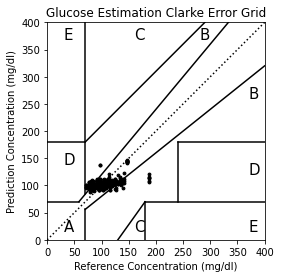

In [41]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators = 390, random_state = 7)
trainTest(model,red)

MAPE: 84.93%
MAE: 15.59
Difference: 5.83


c:\Users\Kazi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.393e+05, tolerance: 9.345e+02
  model = cd_fast.enet_coordinate_descent(


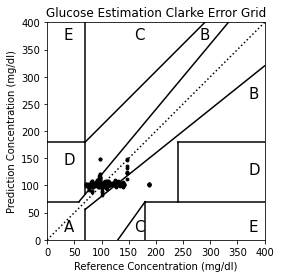

In [42]:
model = ElasticNet(alpha=450, l1_ratio=0.30,fit_intercept=False)
trainTest(model,red)

MAPE: 90.15%
MAE: 9.88
Difference: 8.73


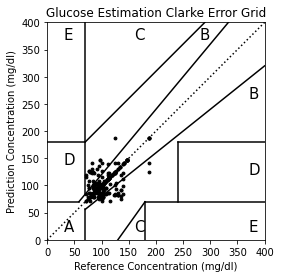

In [43]:
model = KNeighborsRegressor(n_neighbors=1,p=1,weights='distance')
trainTest(model,red)

c:\Users\Kazi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MAPE: 85.52%
MAE: 14.43
Difference: 7.11


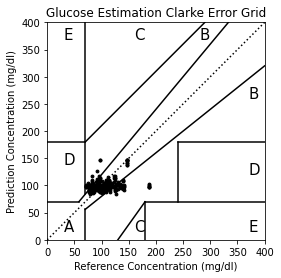

In [44]:
model = SVR(kernel = 'rbf', C = 4000)
trainTest(model,red)

c:\Users\Kazi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MAPE: 85.05%
MAE: 15.43
Difference: 5.83


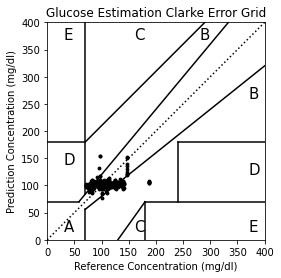

In [45]:
model = BayesianRidge(n_iter=5,fit_intercept=False)
trainTest(model,red)

MAPE: 87.56%
MAE: 12.93
Difference: 5.6


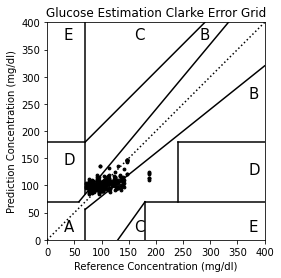

In [46]:
model = XGBRegressor(booster='gbtree',eta=0.09,gamma=0.60)
trainTest(model,red)

c:\Users\Kazi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MAPE: 87.27%
MAE: 13.12
Difference: 5.43


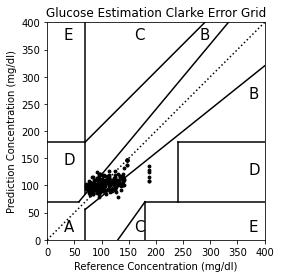

In [47]:
model = HistGradientBoostingRegressor( learning_rate=0.1 , max_iter=600 )
trainTest(model,red)

c:\Users\Kazi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MAPE: 90.3%
MAE: 9.66
Difference: 8.66


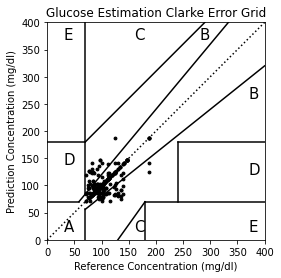

In [48]:
knn = KNeighborsRegressor(n_neighbors=1,p=1,weights='distance')
model = AdaBoostRegressor(base_estimator=knn,n_estimators=9,learning_rate=0.1,random_state=7)
trainTest(model,red)

<h2>Green Intensity Dataset</h2>

C:\Users\Kazi\AppData\Local\Temp\ipykernel_7936\3990588145.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(x_train,y_train)


MAPE: 87.09%
MAE: 13.31
Difference: 6.85


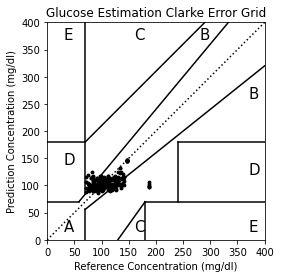

In [49]:
model = RandomForestRegressor(n_estimators = 390, random_state = 7)
trainTest(model,green)

MAPE: 84.28999999999999%
MAE: 16.23
Difference: 5.59


c:\Users\Kazi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.469e+05, tolerance: 9.345e+02
  model = cd_fast.enet_coordinate_descent(


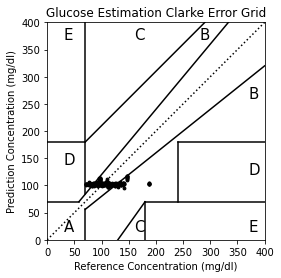

In [50]:
model = ElasticNet(alpha=330, l1_ratio=0.45,fit_intercept=False)
trainTest(model,green)

MAPE: 86.02%
MAE: 14.06
Difference: 8.45


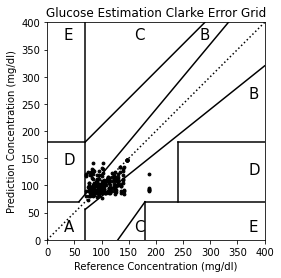

In [51]:
model = KNeighborsRegressor(n_neighbors=3,p=1,weights='distance')
trainTest(model,green)

c:\Users\Kazi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MAPE: 84.03999999999999%
MAE: 15.71
Difference: 6.85


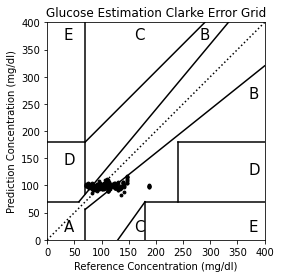

In [52]:
model = SVR(kernel = 'rbf', C = 6000)
trainTest(model,green)

MAPE: 84.45%
MAE: 16.01
Difference: 5.7


c:\Users\Kazi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


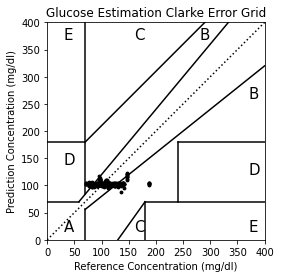

In [53]:
model = BayesianRidge(n_iter=9,fit_intercept=False)
trainTest(model,green)

MAPE: 86.36%
MAE: 14.1
Difference: 7.34


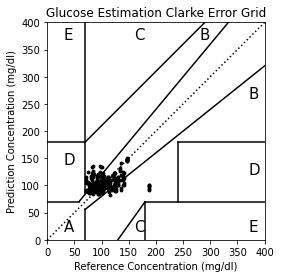

In [54]:
model = XGBRegressor(booster='gbtree',eta=0.09,gamma=0.92)
trainTest(model,green)

c:\Users\Kazi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MAPE: 85.32%
MAE: 14.99
Difference: 7.29


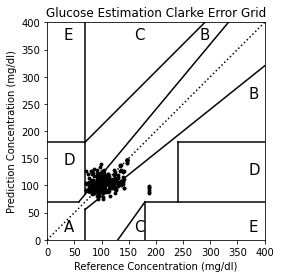

In [55]:
model = HistGradientBoostingRegressor( learning_rate=0.1 , max_iter=600 )
trainTest(model,green)

c:\Users\Kazi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MAPE: 86.8%
MAE: 13.31
Difference: 7.74


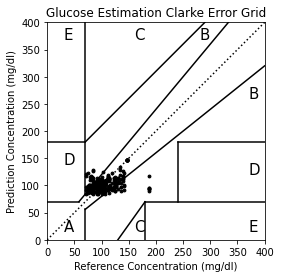

In [56]:
knn = KNeighborsRegressor(n_neighbors=8,p=1,weights='distance')
model = AdaBoostRegressor(base_estimator=knn,n_estimators=15,learning_rate=0.1,random_state=7)
trainTest(model,green)

<h2>Blue Intensity Dataset</h2>

C:\Users\Kazi\AppData\Local\Temp\ipykernel_7936\3990588145.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(x_train,y_train)


MAPE: 86.64%
MAE: 14.04
Difference: 5.8


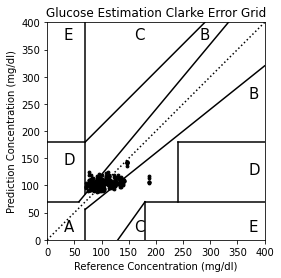

In [57]:
model = RandomForestRegressor(n_estimators = 415, random_state = 7)
trainTest(model,blue)

MAPE: 85.13%
MAE: 15.53
Difference: 5.74


c:\Users\Kazi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.109e+04, tolerance: 9.345e+02
  model = cd_fast.enet_coordinate_descent(


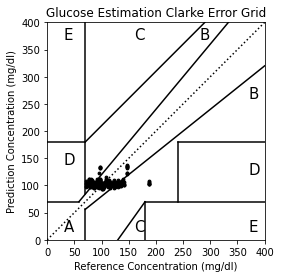

In [58]:
model = ElasticNet(alpha=220, l1_ratio=0.45,fit_intercept=False)
trainTest(model,blue)

MAPE: 86.18%
MAE: 14.35
Difference: 7.37


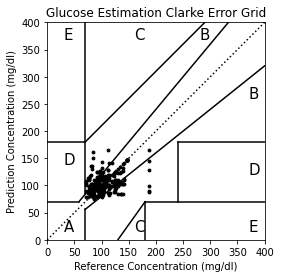

In [59]:
model = KNeighborsRegressor(n_neighbors=2,p=1,weights='distance')
trainTest(model,blue)

c:\Users\Kazi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MAPE: 85.65%
MAE: 14.3
Difference: 6.71


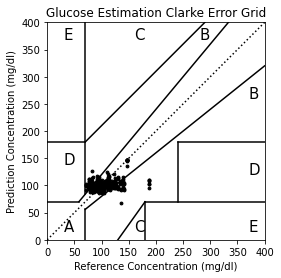

In [60]:
model = SVR(kernel = 'rbf', C = 5000)
trainTest(model,blue)

MAPE: 85.36%
MAE: 15.34
Difference: 5.52


c:\Users\Kazi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


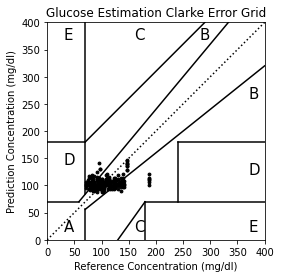

In [61]:
model = BayesianRidge(n_iter=2,fit_intercept=False)
trainTest(model,blue)

MAPE: 86.58%
MAE: 13.97
Difference: 6.11


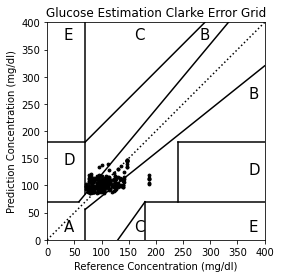

In [62]:
model = XGBRegressor(booster='gbtree',eta=0.09,gamma=0.92)
trainTest(model,blue)

c:\Users\Kazi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MAPE: 86.28%
MAE: 14.37
Difference: 5.96


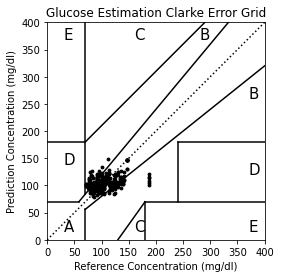

In [63]:
model = HistGradientBoostingRegressor( learning_rate=0.1 , max_iter=600 )
trainTest(model,blue)

c:\Users\Kazi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MAPE: 86.64%
MAE: 14.08
Difference: 5.57


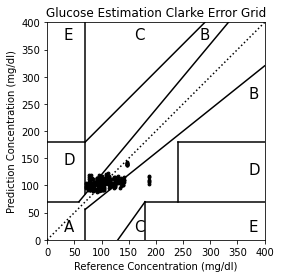

In [64]:
rfr = RandomForestRegressor(n_estimators = 415, random_state = 7)
model = AdaBoostRegressor(base_estimator=rfr,n_estimators=11,learning_rate=0.1,random_state=7)
trainTest(model,blue)

<h2>All Color Intensity Dataset</h2>

C:\Users\Kazi\AppData\Local\Temp\ipykernel_7936\3990588145.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(x_train,y_train)


MAPE: 88.1%
MAE: 12.46
Difference: 6.0


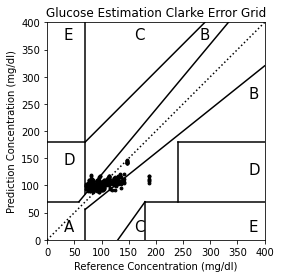

In [65]:
model = RandomForestRegressor(n_estimators = 93, random_state = 7)
trainTest(model,rgb)

MAPE: 86.14%
MAE: 14.42
Difference: 5.88


c:\Users\Kazi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.445e+04, tolerance: 3.708e+01
  model = cd_fast.enet_coordinate_descent(


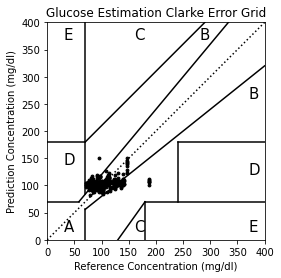

In [66]:
model = ElasticNet(alpha=275, l1_ratio=0.12,fit_intercept=True)
trainTest(model,rgb)

MAPE: 89.32%
MAE: 10.84
Difference: 9.03


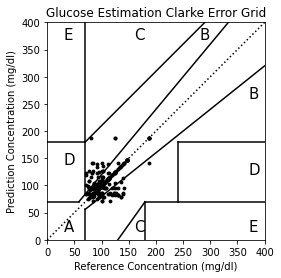

In [67]:
model = KNeighborsRegressor(n_neighbors=1,p=1,weights='distance')
trainTest(model,rgb)

c:\Users\Kazi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MAPE: 86.82%
MAE: 13.14
Difference: 7.14


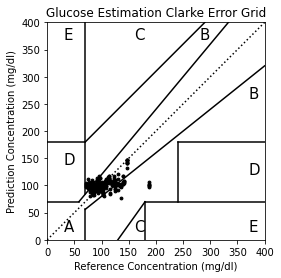

In [68]:
model = SVR(kernel = 'rbf', C = 20000)
trainTest(model,rgb)

c:\Users\Kazi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MAPE: 86.24%
MAE: 14.28
Difference: 5.96


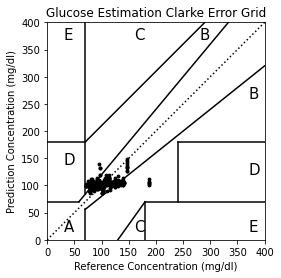

In [69]:
model = BayesianRidge(n_iter=8,fit_intercept=True)
trainTest(model,rgb)

MAPE: 88.24%
MAE: 12.26
Difference: 5.39


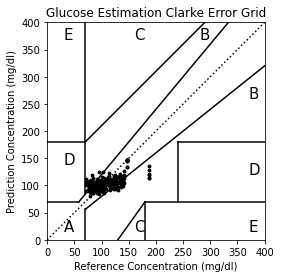

In [70]:
model = XGBRegressor(booster='gbtree',eta=0.092,gamma=0.919)
trainTest(model,rgb)

c:\Users\Kazi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MAPE: 87.95%
MAE: 12.53
Difference: 5.59


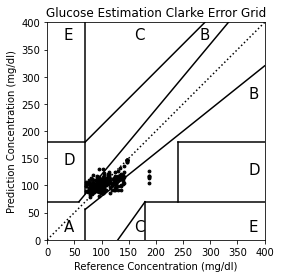

In [71]:
model = HistGradientBoostingRegressor( learning_rate=0.1 , max_iter=600 )
trainTest(model,rgb)

c:\Users\Kazi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MAPE: 89.21000000000001%
MAE: 10.95
Difference: 8.73


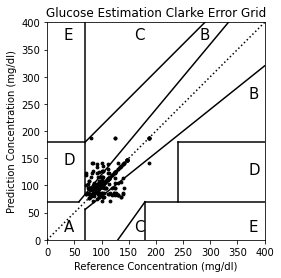

In [72]:
knn = KNeighborsRegressor(n_neighbors=1,p=1,weights='distance')
model = AdaBoostRegressor(base_estimator=knn,n_estimators=10,learning_rate=0.11,random_state=7)
trainTest(model,rgb)

<h1>6 - Measurement Dataset</h1>

C:\Users\Kazi\AppData\Local\Temp\ipykernel_7936\3990588145.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(x_train,y_train)


MAPE: 86.3%
MAE: 14.39
Difference: 6.04


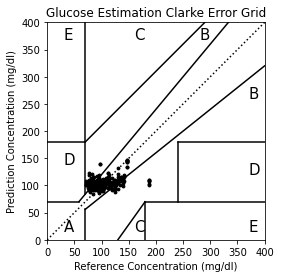

In [73]:
model = RandomForestRegressor(n_estimators = 87, random_state = 7)
trainTest(model,measurement)

MAPE: 84.51%
MAE: 16.01
Difference: 5.72


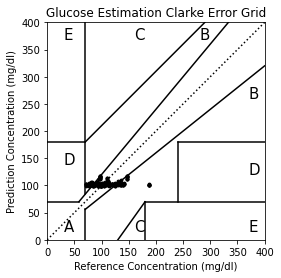

In [74]:
model = ElasticNet( alpha=80, l1_ratio=0.11,fit_intercept=True )
trainTest(model,measurement)

MAPE: 85.77%
MAE: 14.62
Difference: 6.75


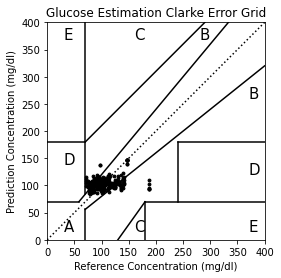

In [75]:
model = KNeighborsRegressor(n_neighbors=11,p=2,weights='distance')
trainTest(model,measurement)

MAPE: 83.78%
MAE: 16.08
Difference: 6.48


c:\Users\Kazi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


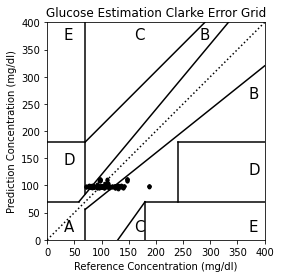

In [76]:
model = SVR(kernel='rbf' , C = 500)
trainTest(model,measurement)

MAPE: 84.47%
MAE: 16.03
Difference: 5.73


c:\Users\Kazi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


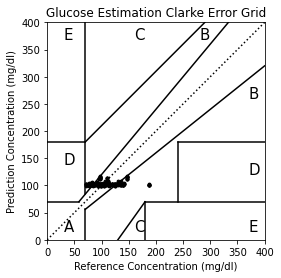

In [77]:
model = BayesianRidge(n_iter=6)
trainTest(model,measurement)

c:\Users\Kazi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MAPE: 86.15%
MAE: 14.52
Difference: 6.07


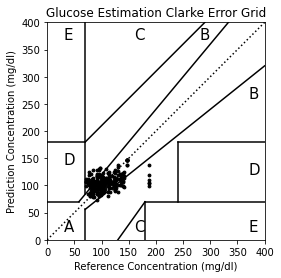

In [78]:
model = HistGradientBoostingRegressor( learning_rate=0.2 , max_iter=700 )
trainTest(model,measurement)

c:\Users\Kazi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MAPE: 85.83%
MAE: 14.72
Difference: 6.57


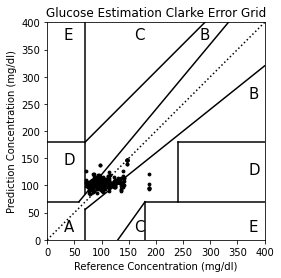

In [79]:
knn = KNeighborsRegressor(n_neighbors=11,p=2,weights='distance')
model = AdaBoostRegressor(base_estimator=knn,n_estimators=60,learning_rate=0.05,random_state=10)
trainTest(model,measurement)

<h1>7 - Measurement-Intensity Datasets</h1>
<br>
<h2>Red Measurement-Intensity Dataset</h2>

C:\Users\Kazi\AppData\Local\Temp\ipykernel_7936\3990588145.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(x_train,y_train)


MAPE: 87.71000000000001%
MAE: 12.89
Difference: 5.39


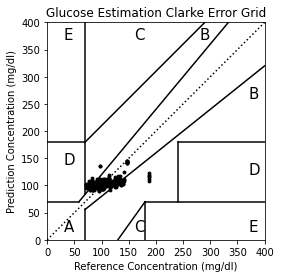

In [80]:
model = RandomForestRegressor(n_estimators=150,criterion='absolute_error',min_samples_split=3,random_state=7)
trainTest(model,red_measurement)

MAPE: 85.1%
MAE: 15.41
Difference: 5.69


c:\Users\Kazi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.433e+02, tolerance: 3.708e+01
  model = cd_fast.enet_coordinate_descent(


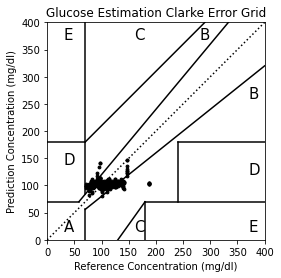

In [81]:
model = ElasticNet( alpha=490, l1_ratio=0.11,fit_intercept=True )
trainTest(model,red_measurement)

MAPE: 90.45%
MAE: 9.85
Difference: 6.88


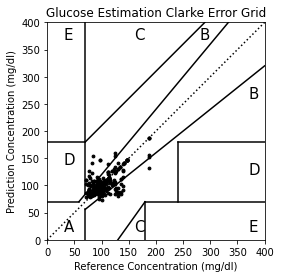

In [82]:
model = KNeighborsRegressor(n_neighbors=2,p=1,weights='distance',metric='minkowski')
trainTest(model,red_measurement)

c:\Users\Kazi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MAPE: 85.56%
MAE: 14.53
Difference: 6.99


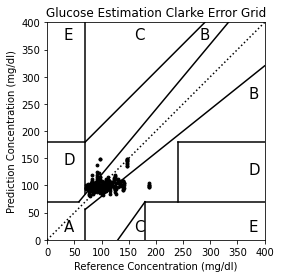

In [83]:
model = SVR( kernel='rbf', C=10000)
trainTest(model,red_measurement)

MAPE: 85.19%
MAE: 15.34
Difference: 5.61


c:\Users\Kazi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


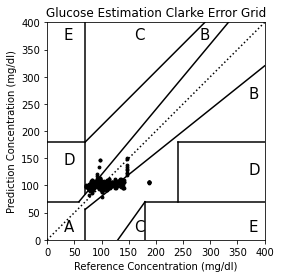

In [84]:
model = BayesianRidge( n_iter=6 )
trainTest(model,red_measurement)

MAPE: 87.78%
MAE: 12.66
Difference: 5.76


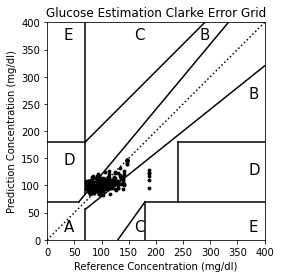

In [85]:
model = XGBRegressor(eta=0.13,gamma=1.9,min_child_weight=2,tree_method='approx')
trainTest(model,red_measurement)

c:\Users\Kazi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MAPE: 86.92%
MAE: 13.55
Difference: 5.55


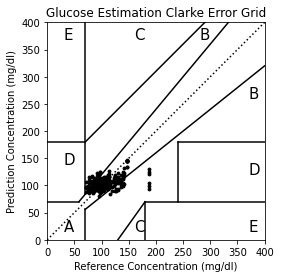

In [86]:
model = HistGradientBoostingRegressor(loss='squared_error',learning_rate=0.08)
trainTest(model,red_measurement)

c:\Users\Kazi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MAPE: 90.99%
MAE: 9.38
Difference: 7.45


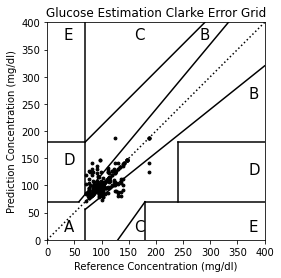

In [87]:
knn = KNeighborsRegressor(n_neighbors=2,p=1,weights='distance',metric='minkowski')
model = AdaBoostRegressor(base_estimator=knn,n_estimators=9,learning_rate=1,random_state=10)
trainTest(model,red_measurement)

<h2>Green Measurement-Intensity Dataset</h2>

C:\Users\Kazi\AppData\Local\Temp\ipykernel_7936\3990588145.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(x_train,y_train)


MAPE: 87.84%
MAE: 12.56
Difference: 6.76


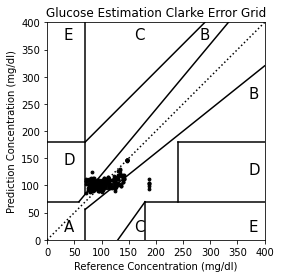

In [88]:
model = RandomForestRegressor(n_estimators=250,random_state=7)
trainTest(model,green_measurement)

MAPE: 85.17%
MAE: 15.24
Difference: 5.73


c:\Users\Kazi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.487e+05, tolerance: 3.708e+01
  model = cd_fast.enet_coordinate_descent(


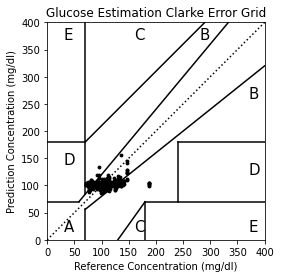

In [89]:
model = ElasticNet( alpha=2 )
trainTest(model,green_measurement)

MAPE: 86.26%
MAE: 13.92
Difference: 8.53


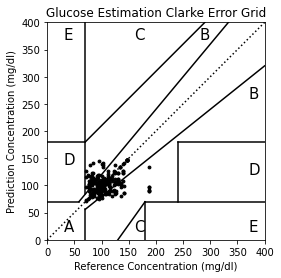

In [90]:
model = KNeighborsRegressor( n_neighbors=2 )
trainTest(model,green_measurement)

c:\Users\Kazi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MAPE: 85.43%
MAE: 14.49
Difference: 6.97


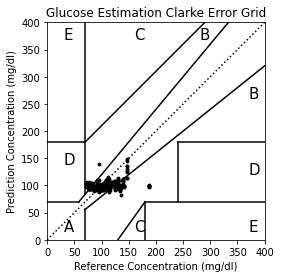

In [91]:
model = SVR( kernel='rbf' , C=22000 )
trainTest(model,green_measurement)

MAPE: 84.83%
MAE: 16.04
Difference: 7.98


c:\Users\Kazi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


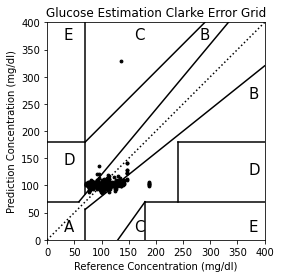

In [92]:
model = BayesianRidge( n_iter=1 )
trainTest(model,green_measurement)

MAPE: 87.85%
MAE: 12.49
Difference: 6.79


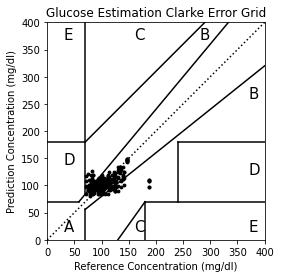

In [93]:
model = XGBRegressor( eta=0.1,gamma=1.8,tree_method='approx' )
trainTest(model,green_measurement)

c:\Users\Kazi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MAPE: 87.55%
MAE: 12.97
Difference: 6.35


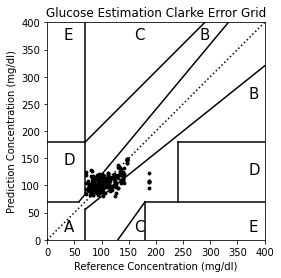

In [94]:
model = HistGradientBoostingRegressor( loss='squared_error',learning_rate=0.1 )
trainTest(model,green_measurement)

c:\Users\Kazi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MAPE: 87.83%
MAE: 12.6
Difference: 6.66


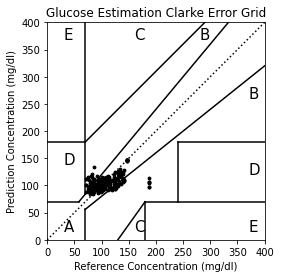

In [95]:
xgb = XGBRegressor( eta=0.1,gamma=1.8,tree_method='approx' )
model = AdaBoostRegressor(base_estimator=xgb,n_estimators=5,learning_rate=1,random_state=10)
trainTest(model,green_measurement)

<h2>Blue Measurement-Intensity Dataset</h2>

C:\Users\Kazi\AppData\Local\Temp\ipykernel_7936\3990588145.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(x_train,y_train)


MAPE: 86.72%
MAE: 13.96
Difference: 5.68


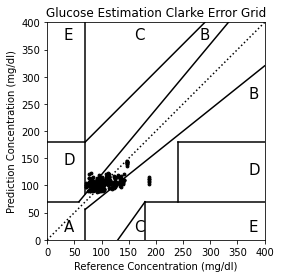

In [96]:
model = RandomForestRegressor(n_estimators=310,random_state=7)
trainTest(model,blue_measurement)

MAPE: 85.56%
MAE: 15.25
Difference: 5.52


c:\Users\Kazi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.943e+04, tolerance: 3.708e+01
  model = cd_fast.enet_coordinate_descent(


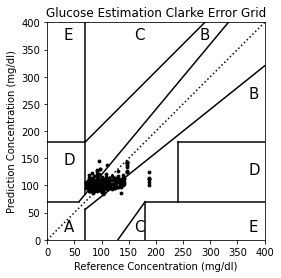

In [97]:
model = ElasticNet( alpha=25 )
trainTest(model,blue_measurement)

MAPE: 85.33%
MAE: 15.61
Difference: 6.5


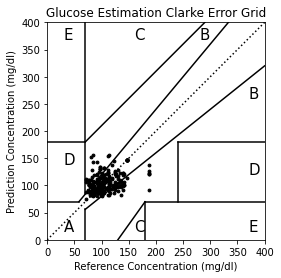

In [98]:
model = KNeighborsRegressor( n_neighbors=3 )
trainTest(model,blue_measurement)

c:\Users\Kazi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MAPE: 85.53999999999999%
MAE: 14.44
Difference: 6.2


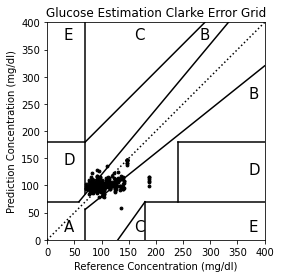

In [99]:
model = SVR( kernel='rbf' , C=27500 )
trainTest(model,blue_measurement)

MAPE: 85.56%
MAE: 15.21
Difference: 5.56


c:\Users\Kazi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


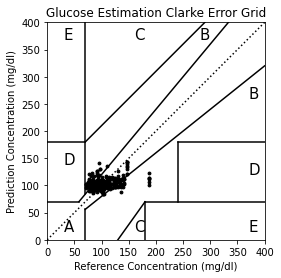

In [100]:
model = BayesianRidge( n_iter=2 )
trainTest(model,blue_measurement)

MAPE: 86.9%
MAE: 13.49
Difference: 6.1


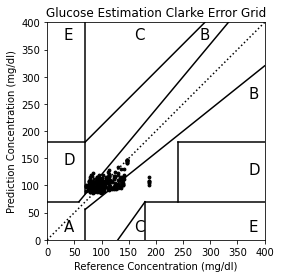

In [101]:
model = XGBRegressor( eta=0.1,gamma=1.8,tree_method='approx' )
trainTest(model,blue_measurement)

c:\Users\Kazi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MAPE: 86.86%
MAE: 13.75
Difference: 5.73


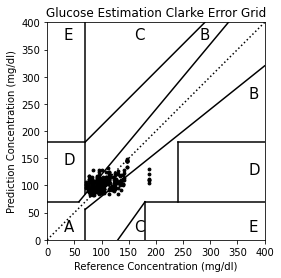

In [102]:
model = HistGradientBoostingRegressor( loss='squared_error',learning_rate=0.10 )
trainTest(model,blue_measurement)

c:\Users\Kazi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MAPE: 87.14%
MAE: 13.38
Difference: 5.58


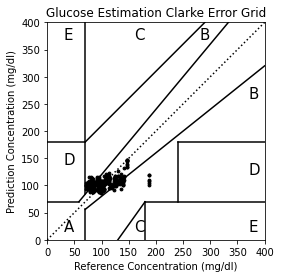

In [103]:
xgb = XGBRegressor( eta=0.1,gamma=1.8,tree_method='approx' )
model = AdaBoostRegressor(base_estimator=xgb,n_estimators=6,learning_rate=1,random_state=10)
trainTest(model,blue_measurement)

<h2>All Color Measurement-Intensity Dataset</h2>

C:\Users\Kazi\AppData\Local\Temp\ipykernel_7936\3990588145.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(x_train,y_train)


MAPE: 87.81%
MAE: 12.7
Difference: 5.96


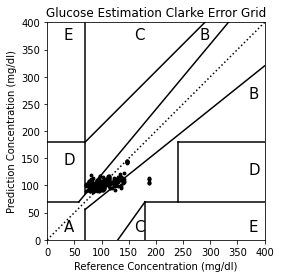

In [104]:
model = RandomForestRegressor(n_estimators=330,random_state=7)
trainTest(model,rgb_measurement)

MAPE: 86.21000000000001%
MAE: 14.38
Difference: 5.91


c:\Users\Kazi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.022e+04, tolerance: 3.708e+01
  model = cd_fast.enet_coordinate_descent(


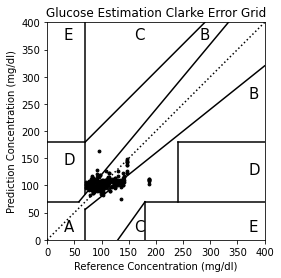

In [105]:
model = ElasticNet(alpha=65)
trainTest(model,rgb_measurement)

MAPE: 88.23%
MAE: 12.39
Difference: 7.11


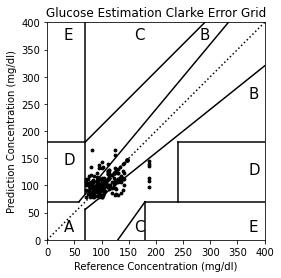

In [106]:
model = KNeighborsRegressor(n_neighbors=2)
trainTest(model,rgb_measurement)

c:\Users\Kazi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MAPE: 86.76%
MAE: 13.28
Difference: 6.83


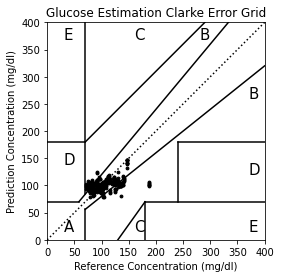

In [107]:
model = SVR( kernel='rbf' , C=25500 )
trainTest(model,rgb_measurement)

c:\Users\Kazi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MAPE: 86.3%
MAE: 14.28
Difference: 5.71


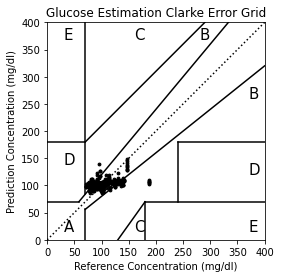

In [108]:
model = BayesianRidge( n_iter=8 )
trainTest(model,rgb_measurement)

MAPE: 87.86%
MAE: 12.61
Difference: 5.64


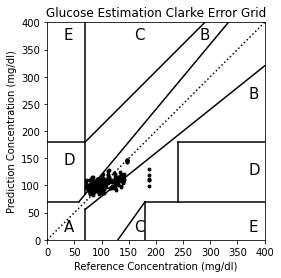

In [109]:
model = XGBRegressor( eta=0.1,gamma=1.8,tree_method='approx' )
trainTest(model,rgb_measurement)

c:\Users\Kazi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MAPE: 88.03%
MAE: 12.48
Difference: 5.65


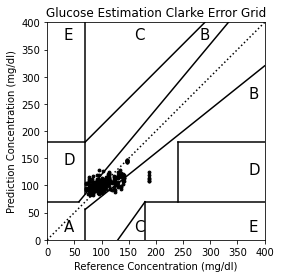

In [110]:
model = HistGradientBoostingRegressor( loss='squared_error',learning_rate=0.05 )
trainTest(model,rgb_measurement)

c:\Users\Kazi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MAPE: 88.22%
MAE: 12.62
Difference: 7.99


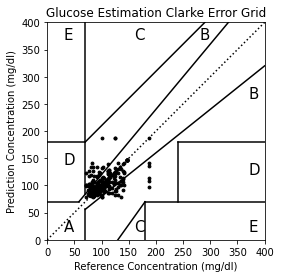

In [111]:
knn = KNeighborsRegressor(n_neighbors=2)
model = AdaBoostRegressor(base_estimator=knn,n_estimators=7,learning_rate=1.2,random_state=10)
trainTest(model,rgb_measurement)

<h1>8 - Timed Datasets</h1>
<br>
<h2>Red Timed Dataset</h2>

C:\Users\Kazi\AppData\Local\Temp\ipykernel_7936\3990588145.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(x_train,y_train)


MAPE: 83.22%
MAE: 17.59
Difference: 3.0


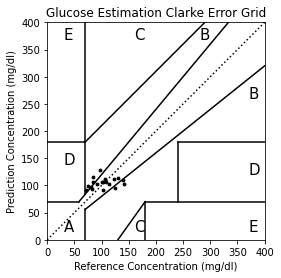

In [112]:
model = RandomForestRegressor(n_estimators=200,random_state=7)
trainTest(model,timed_red)

MAPE: 83.53999999999999%
MAE: 16.99
Difference: 3.8


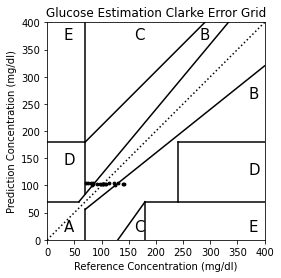

In [113]:
model = ElasticNet( alpha=95 )
trainTest(model,timed_red)

MAPE: 81.36%
MAE: 18.51
Difference: 2.68


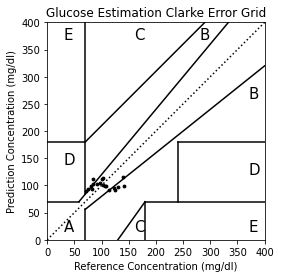

In [114]:
model = KNeighborsRegressor(n_neighbors=8)
trainTest(model,timed_red)

MAPE: 82.21000000000001%
MAE: 17.42
Difference: 3.98


c:\Users\Kazi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


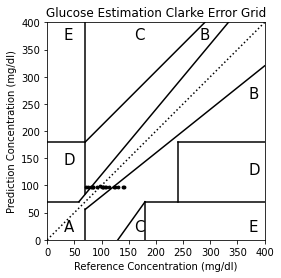

In [115]:
model = SVR(kernel='rbf',C=1)
trainTest(model,timed_red)

MAPE: 83.38%
MAE: 17.15
Difference: 3.7


c:\Users\Kazi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


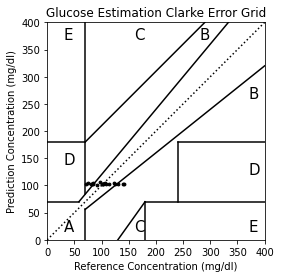

In [116]:
model = BayesianRidge(n_iter=14)
trainTest(model,timed_red)

MAPE: 84.39%
MAE: 16.34
Difference: 4.35


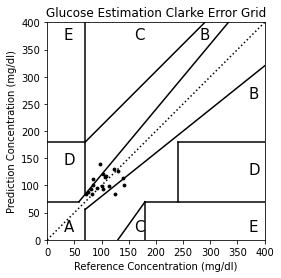

In [117]:
model = XGBRegressor( eta=0.25,gamma=1.8,tree_method='approx' )
trainTest(model,timed_red)

MAPE: 84.73%
MAE: 15.87
Difference: 3.59


c:\Users\Kazi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


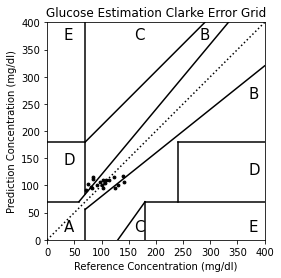

In [118]:
model = HistGradientBoostingRegressor(loss='squared_error',learning_rate=0.075)
trainTest(model,timed_red)

c:\Users\Kazi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MAPE: 83.84%
MAE: 17.45
Difference: 3.7


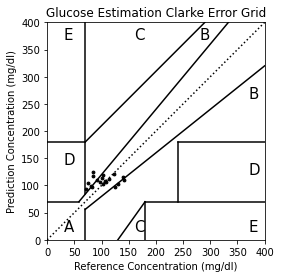

In [119]:
hgbr = HistGradientBoostingRegressor(loss='squared_error',learning_rate=0.075)
model = AdaBoostRegressor(base_estimator=hgbr,learning_rate=1,random_state=10)
trainTest(model,timed_red)

<h2>Green Timed Dataset</h2>

C:\Users\Kazi\AppData\Local\Temp\ipykernel_7936\3990588145.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(x_train,y_train)


MAPE: 84.06%
MAE: 16.49
Difference: 4.01


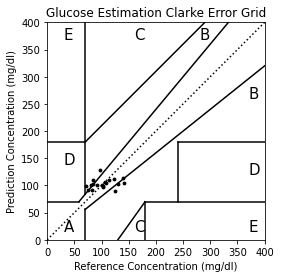

In [120]:
model = RandomForestRegressor(n_estimators=200,random_state=7)
trainTest(model,timed_green)

MAPE: 83.53999999999999%
MAE: 16.99
Difference: 3.8


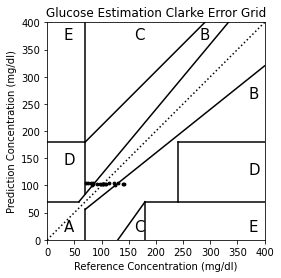

In [121]:
model = ElasticNet( alpha=95 )
trainTest(model,timed_green)

MAPE: 81.63%
MAE: 18.45
Difference: 2.9


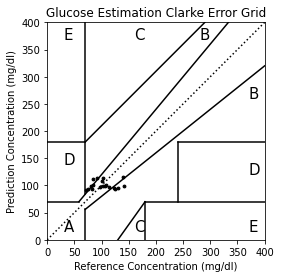

In [122]:
model = KNeighborsRegressor(n_neighbors=8)
trainTest(model,timed_green)

MAPE: 82.21000000000001%
MAE: 17.42
Difference: 3.98


c:\Users\Kazi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


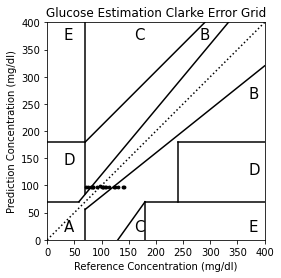

In [123]:
model = SVR(kernel='rbf',C=1)
trainTest(model,timed_green)

MAPE: 83.42%
MAE: 17.09
Difference: 3.72


c:\Users\Kazi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


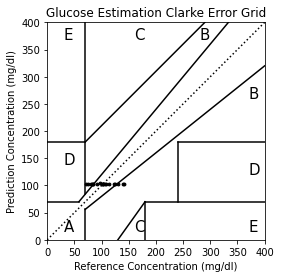

In [124]:
model = BayesianRidge(n_iter=14)
trainTest(model,timed_green)

MAPE: 85.83%
MAE: 14.61
Difference: 4.71


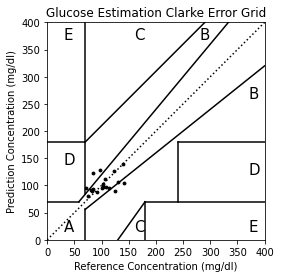

In [125]:
model = XGBRegressor( eta=0.25,gamma=1.8,tree_method='approx' )
trainTest(model,timed_green)

MAPE: 84.63%
MAE: 15.56
Difference: 3.82


c:\Users\Kazi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


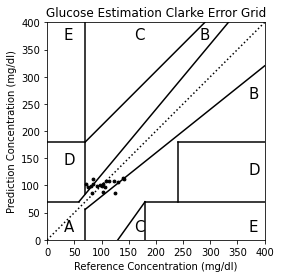

In [126]:
model = HistGradientBoostingRegressor(loss='squared_error',learning_rate=0.075)
trainTest(model,timed_green)

c:\Users\Kazi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MAPE: 83.93%
MAE: 17.27
Difference: 3.91


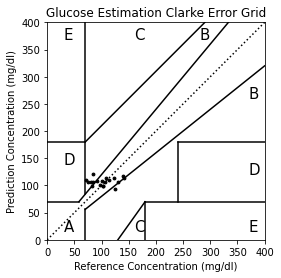

In [127]:
hgbr = HistGradientBoostingRegressor(loss='squared_error',learning_rate=0.075)
model = AdaBoostRegressor(base_estimator=hgbr,learning_rate=1,random_state=10)
trainTest(model,timed_green)

<h2>Blue Timed Dataset</h2>

C:\Users\Kazi\AppData\Local\Temp\ipykernel_7936\3990588145.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(x_train,y_train)


MAPE: 83.34%
MAE: 17.39
Difference: 3.96


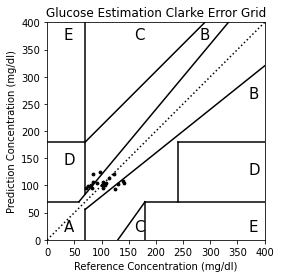

In [128]:
model = RandomForestRegressor(n_estimators=200,random_state=7)
trainTest(model,timed_blue)

MAPE: 83.53999999999999%
MAE: 16.99
Difference: 3.8


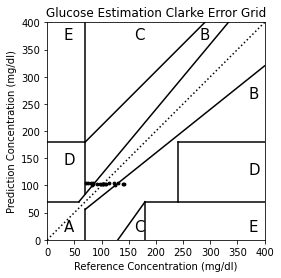

In [129]:
model = ElasticNet( alpha=95 )
trainTest(model,timed_blue)

MAPE: 81.68%
MAE: 18.32
Difference: 3.09


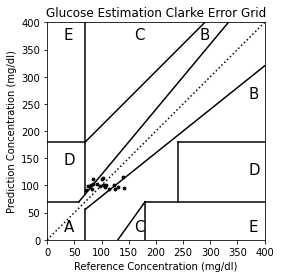

In [130]:
model = KNeighborsRegressor(n_neighbors=8)
trainTest(model,timed_blue)

MAPE: 82.21000000000001%
MAE: 17.42
Difference: 3.98


c:\Users\Kazi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


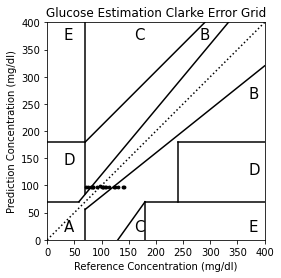

In [131]:
model = SVR(kernel='rbf',C=1)
trainTest(model,timed_blue)

MAPE: 83.36%
MAE: 17.19
Difference: 3.68


c:\Users\Kazi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


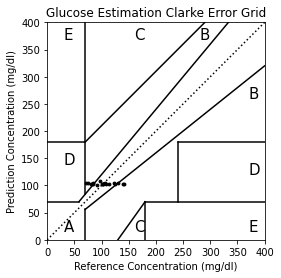

In [132]:
model = BayesianRidge(n_iter=14)
trainTest(model,timed_blue)

MAPE: 85.35%
MAE: 14.7
Difference: 3.17


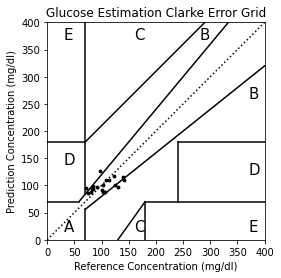

In [133]:
model = XGBRegressor( eta=0.25,gamma=1.8,tree_method='approx' )
trainTest(model,timed_blue)

c:\Users\Kazi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MAPE: 86.68%
MAE: 13.95
Difference: 2.94


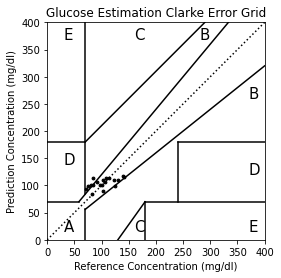

In [134]:
model = HistGradientBoostingRegressor(loss='squared_error',learning_rate=0.075)
trainTest(model,timed_blue)

c:\Users\Kazi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MAPE: 85.86%
MAE: 15.95
Difference: 3.73


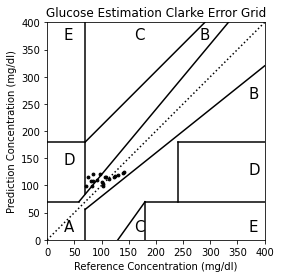

In [135]:
hgbr = HistGradientBoostingRegressor(loss='squared_error',learning_rate=0.075)
model = AdaBoostRegressor(base_estimator=hgbr,learning_rate=1,random_state=10)
trainTest(model,timed_blue)

<h1>9 - Model Summary</h1>
<br>
<h4> <strong>Highest Accuracy Model and Dataset:</strong> AdaBoost with KNeighbors Trained on Red-Intensity Dataset</h4>

c:\Users\Kazi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MAPE: 90.99%
MAE: 9.38
Difference: 7.45


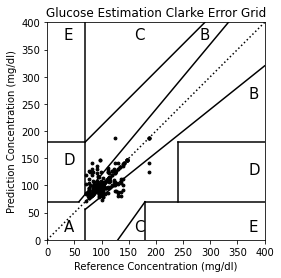

In [136]:
knn = KNeighborsRegressor(n_neighbors=2,p=1,weights='distance',metric='minkowski')
model = AdaBoostRegressor(base_estimator=knn,n_estimators=9,learning_rate=1,random_state=10)
trainTest(model,red_measurement)

<h4>Saving Final Model</h4>

In [137]:
import pickle

pickle.dump(model, open('final_model.sav', 'wb'))

In [138]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

x_train, x_test, y_train, y_test = train_test_split(red_measurement.drop(columns=['Glucose']), red_measurement[['Glucose']].astype('float') ,test_size=0.25,random_state=7)

loaded_model = pickle.load(open('final_model.sav', 'rb'))
preds = loaded_model.predict(x_test)

print('RMSE: ' + str( round(mean_squared_error(preds,y_test,squared=False),2)))
print('MAE: ' + str( round(mean_absolute_error(preds,y_test),2)))
print('Accuracy: ' + str( round(100 - (mean_absolute_percentage_error(preds, y_test)*100),2)) + '%' )

RMSE: 16.83
MAE: 9.38
Accuracy: 90.99%
